# Action Recognition with an Inflated 3D CNN
The tutorial code at the beginning of this notebook uses the [i3d-kinetics-400](https://www.kaggle.com/models/deepmind/i3d-kinetics/tensorFlow1/400/1?tfhub-redirect=true) module, which is a I3D model pre-trained on the kinetics-400 dateset. We first use I3D to make predictions on the UCF101 Dataset, and later use it to predict the activities in our video dataset without additional training. The goal of this exploration is to determine the extent to which models trained on common human activities generalize to a specific medical context. 

Since the kinetics-400 dateset does not appear to feature activities directly related to the type of clinical setting featured in our dataset, the predictions at the end of this notebook are mostly irrelevant to the actual activities in our videos. However, some of the predictions are similar to the activities in our videos. For example, _making bed_ is relevant to our dataset generally, but is not a particularly useful prediction.  

Nonetheless, the structure provided in this exploration offers a blueprint for implementing a pretrained 3D CNN, which is a model architecture that shows promise for the activities we attempted to predict. This could be useful for future transfer learning or ensemble learning efforts that seek to customize these models and improve prediction accuracy. 

**References**

- Tutorial: https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
- UCF101 Dataset: https://www.kaggle.com/datasets/matthewjansen/ucf101-action-recognition

In [33]:
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
# from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

In [167]:
# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()


def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)


def fetch_ucf_video(video):
  """Fetches a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path


# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]


def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while cap.isOpened():
      ret, frame = cap.read()
      if not ret:
        break

      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break

    cap.release()

    if len(frames) < max_frames:
        return None
    
  except Exception as e:
     print(e)
      
  return np.array(frames) / 255.0


def video_to_frames(video_path, img_size, sequence_length):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, img_size)
        frames.append(frame)
        if len(frames) == sequence_length:
            break
    cap.release()

    if len(frames) < sequence_length:
        return None  # Ignore short videos

    return np.array(frames)



def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  gif = imageio.mimsave('./animation.gif', converted_images, duration=40)
  return gif


In [168]:
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"

with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
  
print("Found %d labels." % len(labels))


Found 400 labels.


In [156]:
# List files and ignore .DS_Store if on a Mac
def list_files(directory):
    visible_files = []
    for file in os.listdir(directory):
        if not file.startswith('.'):
            visible_files.append(file)

    return visible_files

## Get dataset and categorize videos
Tutorial code modified here since the URL provided by the TensorFlow docs throws a 403 error

In [157]:
# # Get the list of videos in the dataset.
# ucf_videos = list_ucf_videos()  # 403 Forbidden
ucf_videos = "./ucf101" # Add local path
files = list_files(ucf_videos)
categories = {}
for folder in files:
  ext = folder[-3:len(folder)]
  if ext != "csv":
    all_categories = list_files(f'{ucf_videos}/{folder}')
    for cat in all_categories:
      categories[cat] = []
      for c in categories:
        videos = list_files(f'{ucf_videos}/{folder}/{cat}')
        for v in videos:
          categories[cat].append(v)

print("Found %d videos in %d categories." % (len(ucf_videos), len(categories)))

for category, sequences in categories.items():
  summary = ", ".join(sequences[:2])
  print("%-20s %4d videos (%s, ...)" % (category, len(sequences), summary))


Found 8 videos in 101 categories.
BalanceBeam          1313 videos (v_BalanceBeam_g02_c01.avi, v_BalanceBeam_g13_c05.avi, ...)
SumoWrestling        1414 videos (v_SumoWrestling_g24_c01.avi, v_SumoWrestling_g24_c03.avi, ...)
Surfing              1616 videos (v_Surfing_g21_c03.avi, v_Surfing_g21_c02.avi, ...)
WritingOnBoard       1919 videos (v_WritingOnBoard_g23_c06.avi, v_WritingOnBoard_g23_c05.avi, ...)
FloorGymnastics      1616 videos (v_FloorGymnastics_g04_c05.avi, v_FloorGymnastics_g14_c05.avi, ...)
Mixing               1717 videos (v_Mixing_g24_c01.avi, v_Mixing_g13_c03.avi, ...)
TennisSwing          2121 videos (v_TennisSwing_g12_c02.avi, v_TennisSwing_g13_c06.avi, ...)
HorseRiding          2020 videos (v_HorseRiding_g01_c03.avi, v_HorseRiding_g11_c02.avi, ...)
JumpRope             1818 videos (v_JumpRope_g12_c05.avi, v_JumpRope_g03_c01.avi, ...)
JumpingJack          1515 videos (v_JumpingJack_g16_c03.avi, v_JumpingJack_g16_c02.avi, ...)
BaseballPitch        1919 videos (v_Baseba

In [158]:
# Get a sample cricket video.
video_path = fetch_ucf_video("v_CricketShot_g04_c02.avi")
sample_video = load_video(video_path)

In [159]:
sample_video.shape

(116, 224, 224, 3)

In [ ]:
# Load i3d-kinetics-400 model
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

In [ ]:
def predict(sample_video, print_pred=True):
  # Add a batch axis to the sample video.
  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  probabilities = tf.nn.softmax(logits)

  top_probs = []
  # If using 300
  
  for i in np.argsort(probabilities)[::-1][:10]:
    top = f"{labels[i]:22}: {probabilities[i] * 100:5.2f}%"
    top_probs.append(top)
    
    if print_pred:
      print(f"Top 10 actions: \n{top}")

  return top_probs

In [ ]:
# Print top predictions
p = predict(sample_video)

Top 10 actions:
spraying              : 17.58%
blasting sand         :  8.21%
spray painting        :  8.02%
plastering            :  7.84%
brush painting        :  2.94%
pumping gas           :  2.14%
building cabinet      :  2.00%
welding               :  1.84%
unloading truck       :  1.57%
sanding floor         :  1.49%


In [ ]:
# Try predicting a different video
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  26.3M      0  0:00:02  0:00:02 --:--:-- 26.3M


In [ ]:
# Define video path
video_path = "End_of_a_jam.ogv"
sample_video = load_video(video_path)[:100]
sample_video.shape

(100, 224, 224, 3)

In [ ]:
# Create a GIF of the video
gif = to_gif(sample_video)

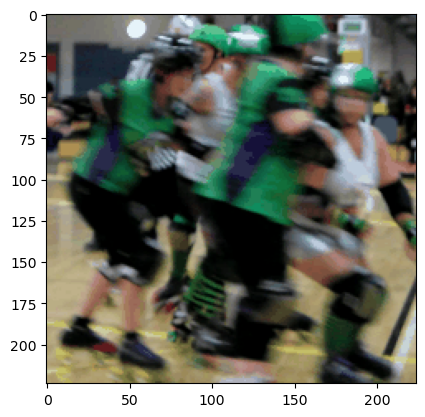

In [ ]:
# Process and display the gif (shows static image)
img = np.asarray(Image.open("./animation.gif").convert('RGB'))
imgplot = plt.imshow(img)
plt.show()

In [ ]:
# Predict the activity
predict(sample_video)

Top actions:
  roller skating: 96.91%
  playing volleyball:  1.60%
  skateboarding:  0.21%
  playing ice hockey:  0.19%
  playing basketball:  0.16%
  catching or throwing softball:  0.12%
  dodgeball:  0.11%
  ice skating:  0.10%
  hockey stop:  0.09%
  dunking basketball:  0.07%


## Predict an activity from our dataset

Shape: (200, 224, 224, 3)


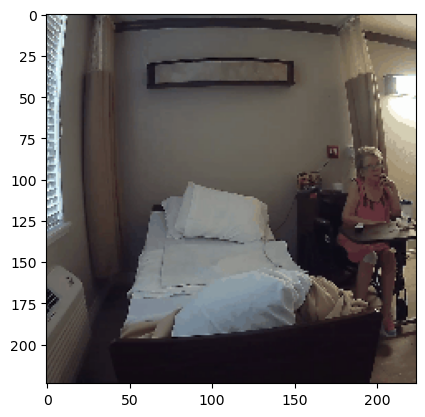

Top 10 actions:
  stretching arm        :  6.43%
  plastering            :  6.32%
  garbage collecting    :  3.75%
  unloading truck       :  2.62%
  spray painting        :  2.43%
  climbing ladder       :  2.25%
  bungee jumping        :  2.21%
  washing hands         :  2.10%
  pull ups              :  1.74%
  punching bag          :  1.58%
None


In [163]:
label = "Talking on the Phone"
video = "7393824945081732241_s_1.mp4"
dir = f"../../downloads/fr_10s"
video_path = f"../../downloads/fr_10s/test_fr_10s/{label}/{video}"

# Load video
sample_video = load_video(video_path)
print("Shape:", sample_video.shape)

# Show a frame from the video for reference
gif = to_gif(sample_video)
img = np.asarray(Image.open("./animation.gif").convert('RGB'))
imgplot = plt.imshow(img)

plt.show()

pred = predict(sample_video)

print(pred)

In [186]:
# Get paths and labels
def load_dataset(folder_path, print_path=False):
    # classes = os.listdir(folder_path)
    classes = list_files(folder_path)
    paths, true_labels, activities = [], [], []

    for label, activity in enumerate(classes):
        activity_folder = os.path.join(folder_path, activity)
        files = list_files(activity_folder)
        num_files = len(files)
        current = 1
        for video_file in files:
            video_path = os.path.join(activity_folder, video_file)
            paths.append(video_path)
            true_labels.append(label)
            activities.append(activity)

            if print_path:
                print(f'{current}/{num_files}\t{video_path}')

            current += 1

    return paths, true_labels, activities


## Predict activities from all videos in our dataset

In [ ]:
# Predict a videos from each class of dataset
path = f"../../downloads/fr_10s/test_fr_10s"
paths, true_labels, activities = load_dataset(path)

all_predictions = []

for p in enumerate(paths):
    
    print(f'{p[0] + 1}/{len(paths)}\t{p[1]}')

    sample_video = load_video(p[1])

    pred = predict(sample_video, print_pred=False)

    all_predictions.append([pred, activities[p[0]], p[1]])

print(pred)

In [ ]:
preds = all_predictions.copy()

In [467]:
# Store unformatted predictions
predictions_list = []
true_labels_list = []
file_paths_list = []

for p in preds:
    predictions_list.append(p[0])
    true_labels_list.append(p[1])
    file_paths_list.append(p[2])

predictions_data = {"Predictions": predictions_list, 
                    "True label": true_labels_list, 
                    "File path": file_paths_list}

predictions_df = pd.DataFrame(predictions_data)

# Save as CSV
dir = "../../performance_data/test_perf"
fname = "2024-11-18-inflated3d-test_fr_10s"
save_path = f"{dir}/{fname}.csv"
predictions_df.to_csv(save_path, index=False)

predictions_df

,Predictions,True label,File path
0,"[spraying : 17.58%, blasting sand...",EVS Visit,../../downloads/fr_10s/test_fr_10s/EVS Visit/7...
1,"[making bed : 50.95%, massaging per...",EVS Visit,../../downloads/fr_10s/test_fr_10s/EVS Visit/7...
2,"[folding napkins : 27.90%, spray paintin...",EVS Visit,../../downloads/fr_10s/test_fr_10s/EVS Visit/7...
3,"[folding napkins : 24.56%, spray paintin...",EVS Visit,../../downloads/fr_10s/test_fr_10s/EVS Visit/7...
4,"[making bed : 74.19%, doing laundry...",EVS Visit,../../downloads/fr_10s/test_fr_10s/EVS Visit/7...
...,...,...,...
1101,"[blowing nose : 14.04%, playing harmo...",Nurse Visit,../../downloads/fr_10s/test_fr_10s/Nurse Visit...
1102,"[taking a shower : 8.33%, plastering ...",Nurse Visit,../../downloads/fr_10s/test_fr_10s/Nurse Visit...
1103,"[trimming or shaving beard: 5.70%, folding na...",Nurse Visit,../../downloads/fr_10s/test_fr_10s/Nurse Visit...
1104,"[massaging legs : 82.29%, waxing legs ...",Transfer To Bed,../../downloads/fr_10s/test_fr_10s/Transfer To...


In [470]:
# Format data
pred_rows = []
true_cats = []
pred_cats = []
probs = []

# Add each predictions as a new row 
for row in predictions_df.iterrows():
    idx = int(row[0])
    tl =  row[1][1]
    row_pred = row[1][0]
    
    for r in enumerate(row_pred):
        pred_idx = r[0]
        pred = r[1]

        # Split strings
        pred = pred.split()
        
        delimit = " "
        joined = delimit.join(pred)

        # Remove whitespace and symbols
        new = joined.split(":")
        category = new[0].strip()
        val = float(new[len(new)-1][:-1].strip())
        
        pred_rows.append(idx)
        true_cats.append(tl)
        pred_cats.append(category)
        probs.append(val)


top_data = {"Video": pred_rows, "True label": true_cats, 
            "Predicted label": pred_cats, "Probability (%)": probs}

top_df = pd.DataFrame(top_data)

# Get top predictions
top = top_df.groupby('Video')['Probability (%)'].nlargest(1)
top_df = top_df.sort_values(['Video', 'Probability (%)'], 
                            ascending=False).groupby('Video').head(10).reset_index(drop=True)

# Add top predictions to DataFrame
top_df['Top prediction'] = top_df.index % 10 == 0
top_df =top_df.sort_values(['Video'], ascending=True).reset_index(drop=True)

# Save as CSV
dir = "../../performance_data/test_perf"
fname = "2024-11-18-inflated3d-test_all"
save_path = f"{dir}/{fname}.csv"
top_df.to_csv(save_path, index=False)

# Show formatted DataFrame
top_df

,Video,True label,Predicted label,Probability (%),Top prediction
0,0,EVS Visit,sanding floor,1.49,False
1,0,EVS Visit,spraying,17.58,True
2,0,EVS Visit,blasting sand,8.21,False
3,0,EVS Visit,spray painting,8.02,False
4,0,EVS Visit,plastering,7.84,False
...,...,...,...,...,...
11055,1105,Transfer To Bed,stretching arm,3.36,False
11056,1105,Transfer To Bed,tickling,6.61,False
11057,1105,Transfer To Bed,waxing legs,10.09,False
11058,1105,Transfer To Bed,massaging feet,10.42,False
